The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install setuptools==65.5.0 "wheel<0.40.0"

**Restart the runtime before run the cell below**

In [ ]:
!pip install d2l==1.0.0-beta0

# Implementation of Multilayer Perceptrons

Multilayer perceptrons (MLPs) are not much more complex to implement than simple linear models. The key conceptual
difference is that we now concatenate multiple layers.


In [ ]:
import tensorflow as tf
from d2l import tensorflow as d2l

### Model

As compared with our concise implementation
of softmax regression implementation,
the only difference is that we add
*two* fully connected layers where we previously added only *one*.
The first is [**the hidden layer**],
the second is the output layer.


In [ ]:
class MLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(num_hiddens, activation='relu'),
            tf.keras.layers.Dense(num_outputs)])

Previously, we defined `forward` methods for models to transform input using the model parameters.
These operations are essentially a pipeline:
you take an input and
apply a transformation (e.g.,
matrix multiplication with weights followed by bias addition),
then repetitively use the output of the current transformation as
input to the next transformation.
However, you may have noticed that 
no `forward` method is defined here.
In fact, `MLP` inherits the `forward` method from the `Module` class to 
simply invoke `self.net(X)` (`X` is input),
which is now defined as a sequence of transformations
via the `Sequential` class.
The `Sequential` class abstracts the forward process
enabling us to focus on the transformations.


### Training

[**The training loop**] is exactly the same
as when we implemented softmax regression.
This modularity enables us to separate
matters concerning the model architecture
from orthogonal considerations.


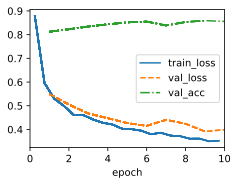

In [ ]:
model = MLP(num_outputs=10, num_hiddens=256, lr=0.1)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

# Implementation of Convolutional Neural Networks (CNNs)

At a high level, (**LeNet (LeNet-5) consists of two parts:
(i) a convolutional encoder consisting of two convolutional layers; and
(ii) a dense block consisting of three fully connected layers**);
The architecture is summarized in below.

![Data flow in LeNet. The input is a handwritten digit, the output a probability over 10 possible outcomes.](http://d2l.ai/_images/lenet.svg)

The basic units in each convolutional block
are a convolutional layer, a sigmoid activation function,
and a subsequent average pooling operation.
Note that while ReLUs and max-pooling work better,
these discoveries had not yet been made at the time.
Each convolutional layer uses a $5\times 5$ kernel
and a sigmoid activation function.
These layers map spatially arranged inputs
to a number of two-dimensional feature maps, typically
increasing the number of channels.
The first convolutional layer has 6 output channels,
while the second has 16.
Each $2\times2$ pooling operation (stride 2)
reduces dimensionality by a factor of $4$ via spatial downsampling.
The convolutional block emits an output with shape given by
(batch size, number of channel, height, width).

In order to pass output from the convolutional block
to the dense block,
we must flatten each example in the minibatch.
In other words, we take this four-dimensional input and transform it
into the two-dimensional input expected by fully connected layers:
as a reminder, the two-dimensional representation that we desire uses the first dimension to index examples in the minibatch
and the second to give the flat vector representation of each example.
LeNet's dense block has three fully connected layers,
with 120, 84, and 10 outputs, respectively.
Because we are still performing classification,
the 10-dimensional output layer corresponds
to the number of possible output classes.

While getting to the point where you truly understand
what is going on inside LeNet may have taken a bit of work,
hopefully the following code snippet will convince you
that implementing such models with modern deep learning frameworks
is remarkably simple.
We need only to instantiate a `Sequential` block
and chain together the appropriate layers.

In [ ]:
class LeNet(d2l.Classifier):  #@save
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(filters=6, kernel_size=5,
                                   activation='sigmoid', padding='same'),
            tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
            tf.keras.layers.Conv2D(filters=16, kernel_size=5,
                                   activation='sigmoid'),
            tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(120, activation='sigmoid'),
            tf.keras.layers.Dense(84, activation='sigmoid'),
            tf.keras.layers.Dense(num_classes)])

We take some liberty in the reproduction of LeNet insofar as we replace the Gaussian activation layer by
a softmax layer. This greatly simplifies the implementation, not the least due to the
fact that the Gaussian decoder is rarely used nowadays. Other than that, this network matches
the original LeNet-5 architecture.


Let's see what happens inside the network. By passing a
single-channel (black and white)
$28 \times 28$ image through the network
and printing the output shape at each layer,
we can [**inspect the model**] to make sure
that its operations line up with
what we expect.


![Compressed notation for LeNet-5.](../d2l-tensorflow-colab/img/lenet-vert.svg)


In [ ]:
@d2l.add_to_class(d2l.Classifier)  #@save
def layer_summary(self, X_shape):
    X = tf.random.normal(X_shape)
    for layer in self.net.layers:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNet()
model.layer_summary((1, 28, 28, 1))

Conv2D output shape:	 (1, 28, 28, 6)
AveragePooling2D output shape:	 (1, 14, 14, 6)
Conv2D output shape:	 (1, 10, 10, 16)
AveragePooling2D output shape:	 (1, 5, 5, 16)
Flatten output shape:	 (1, 400)
Dense output shape:	 (1, 120)


Dense output shape:	 (1, 84)
Dense output shape:	 (1, 10)


Note that the height and width of the representation
at each layer throughout the convolutional block
is reduced (compared with the previous layer).
The first convolutional layer uses 2 pixels of padding
to compensate for the reduction in height and width
that would otherwise result from using a $5 \times 5$ kernel.
As an aside, the image size of $28 \times 28$ pixels in the original
MNIST OCR dataset is a result of *trimming* 2 pixel rows (and columns) from the
original scans that measured $32 \times 32$ pixels. This was done primarily to
save space (a 30% reduction) at a time when Megabytes mattered.

In contrast, the second convolutional layer forgoes padding,
and thus the height and width are both reduced by 4 pixels.
As we go up the stack of layers,
the number of channels increases layer-over-layer
from 1 in the input to 6 after the first convolutional layer
and 16 after the second convolutional layer.
However, each pooling layer halves the height and width.
Finally, each fully connected layer reduces dimensionality,
finally emitting an output whose dimension
matches the number of classes.


## Training

Now that we have implemented the model,
let's [**run an experiment to see how the LeNet-5 model fares on Fashion-MNIST**].

While CNNs have fewer parameters,
they can still be more expensive to compute
than similarly deep MLPs
because each parameter participates in many more
multiplications.
If you have access to a GPU, this might be a good time
to put it into action to speed up training.
Note that
the `d2l.Trainer` class takes care of all details.
By default, it initializes the model parameters on the
available devices.
Just as with MLPs, our loss function is cross-entropy,
and we minimize it via minibatch stochastic gradient descent.


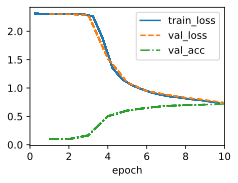

In [ ]:
trainer = d2l.Trainer(max_epochs=10)
data = d2l.FashionMNIST(batch_size=128)
with d2l.try_gpu():
    model = LeNet(lr=0.1)
    trainer.fit(model, data)